# Dataset

Eight target categories are available in this dataset: Albacore tuna, Bigeye tuna, Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other (meaning that there are fish present but not in the above categories), and No Fish (meaning that no fish is in the picture). Each image has only one fish category, except that there are sometimes very small fish in the pictures that are used as bait. 

The dataset was compiled by The Nature Conservancy in partnership with Satlink, Archipelago Marine Research, the Pacific Community, the Solomon Islands Ministry of Fisheries and Marine Resources, the Australia Fisheries Management Authority, and the governments of New Caledonia and Palau.

The original objective of this datset is to stop illegal and overfishing of threatened and endangered fish (+ sharks).

![alt text](https://kaggle2.blob.core.windows.net/competitions/kaggle/5568/media/species-ref-key.jpg "Target Fish")

In [1]:

from sklearn import datasets as ds
import pandas as pd
import numpy as np
import os, os.path
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
import colorsys
import copy
from PIL import Image

from sklearn.decomposition import KernelPCA
import zipfile

import skimage
from skimage import io

from skimage.transform import resize
from random import shuffle
import seaborn as sns

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np

import re


# define X and y here.
import glob2
from PIL import Image
import matplotlib.image as mpimg




In [2]:
image_data = []
image_labels = []

directory = "./train"
os.walk(directory)
folder_names = [x[0] for x in os.walk(directory)]
del folder_names[0]
print(folder_names)
categories = {category.replace('./train\\', '') for category in folder_names}
print(categories)

['./train\\ALB', './train\\BET', './train\\DOL', './train\\LAG', './train\\NoF', './train\\OTHER', './train\\SHARK', './train\\YFT']
{'OTHER', 'LAG', 'NoF', 'BET', 'ALB', 'DOL', 'SHARK', 'YFT'}


In [3]:
%%time
fish_image_files = glob2.glob('train/**/*.jpg')
size = 300, 300

igs = np.array([skimage.transform.resize(skimage.io.imread(fname, as_grey=True, plugin=None, flatten=None),(300,300))
                                         for fname in fish_image_files])

Wall time: 4min 22s


In [7]:
image_labels = []
for fname in fish_image_files:
    image_labels.append(re.sub('/img.*', '', fname.replace('train/', '')))

## Dimension Reduction using Principal Component Analysis

In [8]:
ig_data = igs.astype('float32')
ig_data = ig_data / 255
igs_pca = ig_data.reshape(igs.shape[0], (ig_data.shape[1]*ig_data.shape[2]))
igs_pca.shape

(3777, 90000)

In [10]:
# PCA of the features and go from 90000 features to 180 features
from sklearn.decomposition import PCA

n_components = 173
print ("Extracting the top %d eigenfishes from %d fishes" % (
    n_components, igs_pca.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(igs_pca)
eigenfishes = pca.components_.reshape((n_components, ig_data.shape[1]*ig_data.shape[2]))

Extracting the top 173 eigenfishes from 3777 fishes
Wall time: 40 s


In [11]:
eigenfishes.shape

(173, 90000)

In [6]:
#train_data = igs.astype('float32')
#train_data = train_data / 255
#igs_pca = train_data.reshape(igs.shape[0], (train_data.shape[1]*train_data.shape[2]))
X = igs_pca
y = np.asarray(image_labels)

### Splitting the data

We chose to do a single 80/20 train test split. This is because of the long train times. A k-fold split would be impractical and doing a shuffle split of a large size is also impractical. We may be able to do 2 or 3 shuffle splits, but that does not do much more for us than having 1 shuffle split.

In [ ]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=3, test_size=.20, random_state=0)
rs.get_n_splits(X)
for train_index, test_index in rs.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    # train all the models
    # evaluate all the models

In [7]:
# Split it into train / test subsets TEMPORARY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(3021, 300, 300)

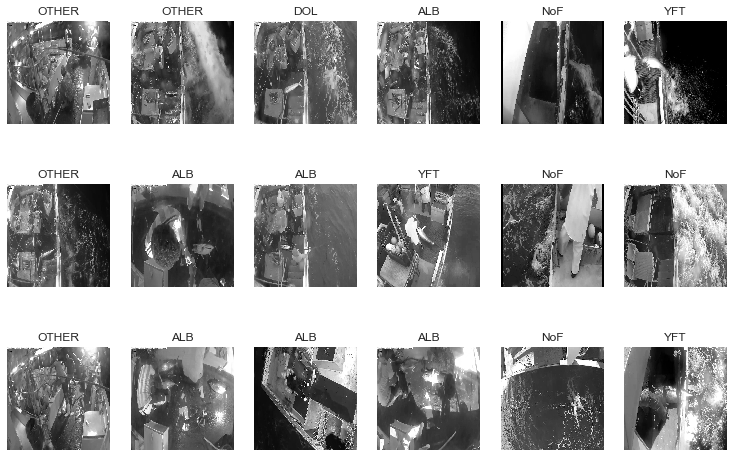

In [8]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 8, 8) # defaults to showing a 3 by 6 subset of the images

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

Using TensorFlow backend.


'2.0.3'

In [10]:
NUM_CLASSES = 8

print(X_train.shape)
print(X_test.shape)

(3021, 300, 300)
(756, 300, 300)


In [13]:
#vectorize images
X_train = X_train.reshape(3021, 90000)
X_test = X_test.reshape(756, 90000)

In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
list(le.classes_)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [15]:
print(le.classes_)

['ALB' 'BET' 'DOL' 'LAG' 'NoF' 'OTHER' 'SHARK' 'YFT']


# Cost Matrix and Custom Scorer

In [16]:
# ask how to make this all under 1
cost_matrix = np.matrix([[0,1,1,1,1,1,1,1],
[1.5,0,1.5,1.5,1.5,1.5,1.5,1.5],
[.5,0,.5,.5,.5,.5,.5,.5],
[1,1,1,0,1,1,1,1],
[1,1,1,1,0,1,1,1],
[1,1,1,1,1,0,1,1],
[2,2,2,2,2,2,0,2],
[1.25,1.25,1.25,1.25,1.25,1.25,1.25,0]])

def get_confusion_costTot(confusion_matrix, cost_matrix):
    score = np.sum(confusion_matrix*cost_matrix)
    return score

We decided to create a custom scorer with a cost matrix. This is because each of the missclassifications have should have different costs associated with them. For instance many sharks are endangered and protected, so misclassifying a shark is worth more than misclassifying a common species, such as the dolphinfish. These are the metrics taken into account for deciding the worth of classifying and misclassifying each of the classes.

'ALB' = Albacore tuna. Common fish.

'BET' = Bigeye tuna. Threatened fish.

'DOL' = Dolphinfish. Extremely common fish.

'LAG' = Opah, Moonfish. Not much is known about this species as they are Deep water fishes.

'SHARK' = Various sharks. Endangered and most illegally fished.

'YFT' = Yellowfin tuna. Threatened fish, but not as much as the bigeye tuna.

In [17]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

CPU times: user 23min 15s, sys: 5min 6s, total: 28min 22s
Wall time: 23min 43s


In [ ]:
#%%time

# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add(Reshape((1,300,300), input_shape=(1,90000)))
cnn.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,300,300)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

In [18]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        #acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        acc_cnn = get_confusion_costTot(cm, cost_matrix)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        #acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        acc_mlp = get_confusion_costTot(cm, cost_matrix)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

In [20]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

ValueError: Error when checking : expected dense_1_input to have 2 dimensions, but got array with shape (756, 1, 90000)

In [ ]:
%%time

# changes: 
#    1. increased kernel size
cnn2 = Sequential()
cnn2.add(Reshape((1,300,300), input_shape=(1,90000)))
cnn2.add(Conv2D(filters=16, kernel_size= (3, 3), padding='same', input_shape=(1,300,300)))
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn2.add(Flatten())
cnn2.add(Dense(NUM_CLASSES))
cnn2.add(Activation('softmax'))

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

In [ ]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
cnn3 = Sequential()
cnn3.add(Reshape((1,300,300), input_shape=(1,90000)))

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn3.add(Activation('relu'))
    cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn3.add(Flatten())
cnn3.add(Dense(NUM_CLASSES))
cnn3.add(Activation('softmax'))

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn3.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=100, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn3,mlp,X_test,y_test)

In [ ]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn4 = Sequential()
cnn4.add(Reshape((1,300,300), input_shape=(1,90000)))

num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn4.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn4.add(Flatten())
cnn4.add(Dense(100))
cnn4.add(Activation('relu'))
cnn4.add(Dense(NUM_CLASSES))
cnn4.add(Activation('softmax'))

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn4.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=64, epochs=100, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn4,mlp,X_test,y_test)

# Exceptional Work 

### Analyzing filters used

In [ ]:
max_plots = 15
for layer in cnn4.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()

### weights before and after filters